In [1]:
import numpy as np
import copy 
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dict_param = np.load('../data/dict_param_all_12.npy', allow_pickle=True).item()
bipartite = dict_param['poi_cbg_visits_list'][0]
unvax = dict_param['unvax']

vax_2022 = pd.read_csv('../data/vac_inferred_lvm_20229.csv')
unvax = np.zeros_like(dict_param['unvax'])

for i, row in vax_2022.iterrows():
    census_block_group = int(row['census_block_group'])
    vac_rate_inferred = row['vac_rate_inferred']
    if census_block_group in dict_param['cbgs_to_idxs']:
        unvax[dict_param['cbgs_to_idxs'][census_block_group]] = 1 - vac_rate_inferred / 100


bipartite = np.load('../data/bipartite_weight_12.npy', allow_pickle=True).item()
bipartite_normed_product = np.load('../results/centrality_files/bipartite_normed_product_all_12.npy', allow_pickle=True)
centrality_scores_array = np.array(bipartite_normed_product)

In [3]:
data = np.load('../data/campaign_2022.npz')


(array([1.86626e+05, 8.91000e+02, 8.43000e+02, 8.12000e+02, 7.35000e+02,
        7.45000e+02, 7.09000e+02, 6.48000e+02, 6.59000e+02, 6.69000e+02,
        5.98000e+02, 5.35000e+02, 5.44000e+02, 5.18000e+02, 4.75000e+02,
        4.62000e+02, 4.62000e+02, 4.07000e+02, 3.57000e+02, 4.21000e+02,
        3.83000e+02, 3.80000e+02, 3.62000e+02, 3.64000e+02, 3.30000e+02,
        2.80000e+02, 3.15000e+02, 3.01000e+02, 3.07000e+02, 2.67000e+02,
        3.09000e+02, 2.97000e+02, 2.64000e+02, 2.59000e+02, 2.48000e+02,
        2.22000e+02, 2.43000e+02, 2.30000e+02, 2.30000e+02, 1.93000e+02,
        1.91000e+02, 1.94000e+02, 1.93000e+02, 1.95000e+02, 2.00000e+02,
        1.59000e+02, 1.77000e+02, 1.80000e+02, 1.92000e+02, 9.11600e+03]),
 array([-4.22908300e-05,  1.95855412e-03,  3.95939908e-03,  5.96024403e-03,
         7.96108898e-03,  9.96193393e-03,  1.19627789e-02,  1.39636238e-02,
         1.59644688e-02,  1.79653137e-02,  1.99661587e-02,  2.19670036e-02,
         2.39678486e-02,  2.59686936e-02

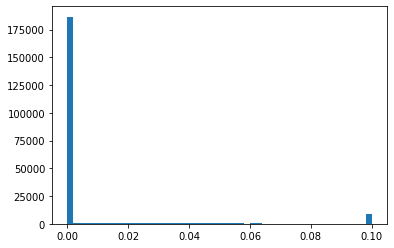

In [4]:
v = copy.deepcopy(data['v'])
v = - v
plt.hist(v, bins=50)

## This figure shows that most targeted CBGs are suggested to increase vax rates by 10%

In [5]:
v = unvax - np.maximum(unvax - v, 0)

In [6]:
cbgs_to_idxs = dict_param['cbgs_to_idxs'] 
cbgs = [cbg for cbg in cbgs_to_idxs]

In [7]:
cbg_sizes = dict_param['cbg_sizes']

## we use binary search to find the best matches (based on the number of encouraged people) for the optimal strategy

In [8]:
def idx_vector_to_decisions(idx):
    cbg_vector = np.zeros(len(cbgs))
    cbg_vector[idx] = 0.1
    cbg_vector = unvax - np.maximum(unvax - cbg_vector, 0)
    return cbg_vector

def cbg_vector_num_people(cbg_vector):
    return np.dot(cbg_vector, cbg_sizes)

def estimation_case(cbg_vector):
    return ((unvax - cbg_vector) @ bipartite.T) @ (bipartite @ (unvax - cbg_vector))

In [9]:
def binary_division(target_cbg_number, vector_to_rank):
#     print(vector_to_rank)
    max_feasible = np.ones(len(vector_to_rank)) * 0.1 
    max_feasible = unvax - np.maximum(0, unvax - max_feasible)
    right = 100
    left = 0
    mid = (right + left) / 2
    T = 0
    while np.abs(np.dot(cbg_sizes[vector_to_rank > np.percentile(vector_to_rank, mid)], max_feasible[vector_to_rank > np.percentile(vector_to_rank, mid)]).sum() - target_cbg_number) > 1000 and T < 100:
        if np.dot(cbg_sizes[vector_to_rank > np.percentile(vector_to_rank, mid)], max_feasible[vector_to_rank > np.percentile(vector_to_rank, mid)]).sum() - target_cbg_number > 0:
            left = mid
        else:
            right = mid
        mid = (left + right) / 2
        T += 1
    
    return vector_to_rank > np.percentile(vector_to_rank, mid), max_feasible * (vector_to_rank > np.percentile(vector_to_rank, mid))

In [10]:
cbg_vector_num_people(v), estimation_case(v)

(3155047.5899999994, 47372032.937062114)

In [11]:
target = cbg_vector_num_people(v)
print(target)
target_lowest_vaccination, target_lowest_vaccination_increase = binary_division(target, unvax)

3155047.5899999994


In [12]:
target = cbg_vector_num_people(v)
print(target)
target_highest_centrality, target_highest_centrality_increase = binary_division(target, centrality_scores_array)

3155047.5899999994


In [13]:
target = cbg_vector_num_people(v)
print(target)
target_random, target_random_increase = binary_division(target, np.random.random(len(v)))

3155047.5899999994


In [14]:
for delta in [v, target_highest_centrality_increase, target_lowest_vaccination_increase, target_random_increase]:
    print(estimation_case(delta), np.dot(cbg_sizes, delta))

47372032.937062114 3155047.5899999994
48542327.48400745 3155208.9259606004
53263985.58605567 3155379.3999999994
53474042.174021706 3155083.8133294904


In [16]:
np.save('../results/campaign/v_2022.npy', v)
np.save('../results/campaign/target_highest_centrality_increase_2022.npy', target_highest_centrality_increase)
np.save('../results/campaign/target_lowest_vaccination_increase_2022.npy', target_lowest_vaccination_increase)
np.save('../results/campaign/target_random_increase_2022.npy', target_random_increase)

# plot the results

In [ ]:
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=1
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=2
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=3
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=4
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=5

In [1]:
import numpy as np

res = {}
res['original'] = np.load('../results/results_all_original_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_0.700000.npy', allow_pickle=True).item()
res['original'] = res['original'][(-1.0, 0.001, 0.005, 120000000.0, 720, False)]
S = res['original']['original']['all']['new_cases'][:, :].sum(axis=1)
S = S.mean()

In [2]:
S

4431862.44

In [3]:
key = (-1.0, 0.001, 0.005, 120000000.0, 720, False)

res['proposed'] = np.load('../results/results_all_original_720_intervene_1_120000000_0.64_2022_new_natural_imm_perfect_0.700000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['centrality'] = np.load('../results/results_all_original_720_intervene_2_120000000_0.64_2022_new_natural_imm_perfect_0.700000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['lowest'] = np.load('../results/results_all_original_720_intervene_3_120000000_0.64_2022_new_natural_imm_perfect_0.700000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['random'] = np.load('../results/results_all_original_720_intervene_4_120000000_0.64_2022_new_natural_imm_perfect_0.700000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['untarget'] = np.load('../results/results_all_original_720_intervene_5_120000000_0.64_2022_new_natural_imm_perfect_0.700000_given_dis.npy', allow_pickle=True).item()[key]['original']

In [10]:
res['untarget'].history['']

{'all': {'total_pop': 315504759,
  'num_cbgs': 214697,
  'new_cases': array([[    0.,    16.,    44., ..., 13645., 13617., 13724.],
         [    0.,    15.,    33., ..., 13607., 13596., 13763.],
         [    0.,    17.,    51., ..., 13581., 13582., 13650.],
         ...,
         [    0.,    19.,    33., ..., 13531., 13596., 13731.],
         [    0.,    25.,    39., ..., 13612., 13735., 13766.],
         [    0.,    26.,    43., ..., 13543., 13619., 13719.]]),
  'new_cases_from_poi': array([[    0.,    16.,    34., ..., 10183., 10020., 10044.],
         [    0.,    13.,    30., ..., 10030., 10128., 10187.],
         [    0.,    13.,    47., ..., 10082., 10004., 10153.],
         ...,
         [    0.,    18.,    32., ...,  9942., 10005., 10175.],
         [    0.,    20.,    34., ..., 10069., 10243., 10109.],
         [    0.,    25.,    35., ..., 10061., 10073., 10185.]]),
  'new_cases_from_base': array([[0.000e+00, 0.000e+00, 1.000e+01, ..., 3.462e+03, 3.597e+03,
          3.680e+

0.02724526801874294 0.027023934434210584 0.03403829474454545 0.08137467371392515 0.09492836154003015


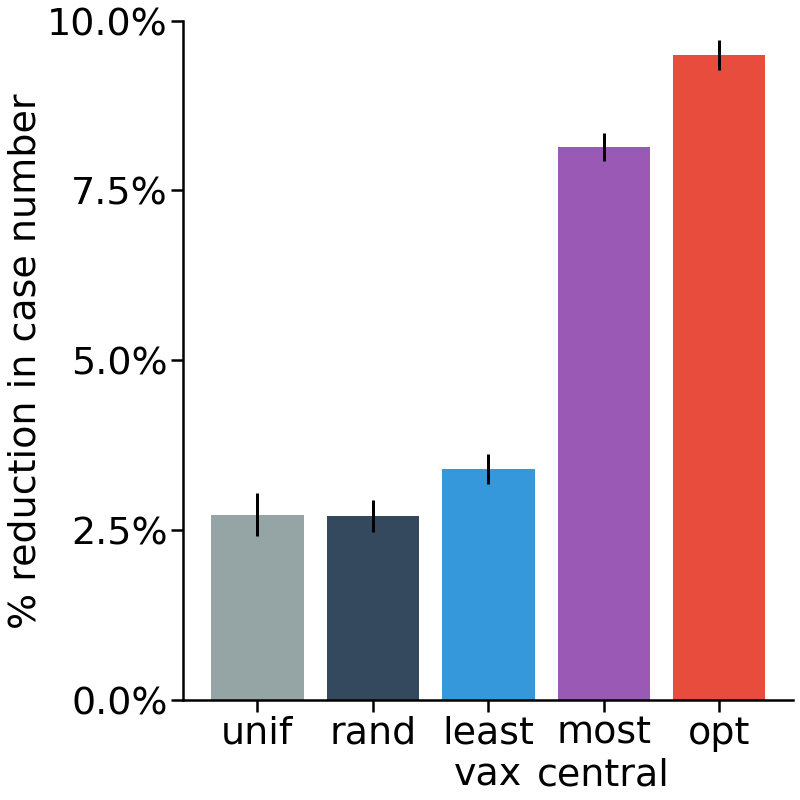

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#95a5a6', '#34495e', '#3498db', '#9b59b6', '#e74c3c'])

plt.bar([0], 
             [1-(res['untarget'].history['all']['new_cases'][:, :].sum(axis=1) / S).mean()],
             yerr=[(res['untarget'].history['all']['new_cases'][:, :].sum(axis=1) / S).std()],
            )

plt.bar([1], 
             [1-(res['random'].history['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['random'].history['all']['new_cases'].sum(axis=1) / S).std()],
            )


plt.bar([2], 
             [1-(res['lowest'].history['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['lowest'].history['all']['new_cases'].sum(axis=1) / S).std()],
            )

plt.bar([3], 
             [1-(res['centrality'].history['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['centrality'].history['all']['new_cases'].sum(axis=1) / S).std()],
            )


plt.bar([4], 
             [(1-res['proposed'].history['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['proposed'].history['all']['new_cases'].sum(axis=1) / S).std()],
            )

print(1-(res['untarget'].history['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['random'].history['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['lowest'].history['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['centrality'].history['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['proposed'].history['all']['new_cases'].sum(axis=1) / S).mean()
     )

sns.despine()

plt.xticks([0,1,2,3,4], ['unif', 'rand', 'least\nvax', 'most\ncentral', 'opt'], fontsize=38)
# plt.axhline(1.0, linestyle='--', color='#bdc3c7')
plt.yticks([0, 0.025, 0.05, 0.075, 0.1, 
            0.125, 0.150, 0.175, 0.2],
           [
               '0.0%', '2.5%', '5.0%', '7.5%',
               '10.0%', '12.5%', '15.0%', '17.5%', '20.0%'], fontsize=38
          )

plt.ylabel('% reduction in case number', fontsize=38)
plt.tight_layout()
plt.ylim((0, .1))
plt.savefig('../results/target_720_2022.pdf')

In [5]:
import numpy as np

res = {}
res['original'] = np.load('../results/results_all_original_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_1.000000.npy', allow_pickle=True).item()
res['original'] = res['original'][(-1.0, 0.001, 0.005, 120000000.0, 720, False)]
S = res['original']['original']['all']['new_cases'][:, :].sum(axis=1)
S = S.mean()

In [6]:
key = (-1.0, 0.001, 0.005, 120000000.0, 720, False)

res['proposed'] = np.load('../results/results_all_original_720_intervene_1_120000000_0.64_2022_new_natural_imm_perfect_1.000000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['centrality'] = np.load('../results/results_all_original_720_intervene_2_120000000_0.64_2022_new_natural_imm_perfect_1.000000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['lowest'] = np.load('../results/results_all_original_720_intervene_3_120000000_0.64_2022_new_natural_imm_perfect_1.000000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['random'] = np.load('../results/results_all_original_720_intervene_4_120000000_0.64_2022_new_natural_imm_perfect_1.000000_given_dis.npy', allow_pickle=True).item()[key]['original']
res['untarget'] = np.load('../results/results_all_original_720_intervene_5_120000000_0.64_2022_new_natural_imm_perfect_1.000000_given_dis.npy', allow_pickle=True).item()[key]['original']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#95a5a6', '#34495e', '#3498db', '#9b59b6', '#e74c3c'])

plt.bar([0], 
             [1-(res['untarget']['all']['new_cases'][:, :].sum(axis=1) / S).mean()],
             yerr=[(res['untarget']['all']['new_cases'][:, :].sum(axis=1) / S).std()],
            )

plt.bar([1], 
             [1-(res['random']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['random']['all']['new_cases'].sum(axis=1) / S).std()],
            )


plt.bar([2], 
             [1-(res['lowest']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['lowest']['all']['new_cases'].sum(axis=1) / S).std()],
            )

plt.bar([3], 
             [1-(res['centrality']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['centrality']['all']['new_cases'].sum(axis=1) / S).std()],
            )


plt.bar([4], 
             [(1-res['proposed']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['proposed']['all']['new_cases'].sum(axis=1) / S).std()],
            )

print(1-(res['untarget']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['random']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['lowest']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['centrality']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['proposed']['all']['new_cases'].sum(axis=1) / S).mean()
     )

sns.despine()

plt.xticks([0,1,2,3,4], ['untargeted', 'random', 'least vaccinated', 'most central', 'optimized'], rotation=30, fontsize=25)
# plt.axhline(1.0, linestyle='--', color='#bdc3c7')
plt.yticks([0, 0.025, 0.05, 0.075, 0.1, 
            0.125, 0.150, 0.175, 0.2],
           [
               '0.0%', '2.5%', '5.0%', '7.5%',
               '10.0%', '12.5%', '15.0%', '17.5%', '20.0%']
          )

plt.ylabel('% reduction in case number')
plt.tight_layout()
plt.ylim((0, None))
plt.savefig('../results/target_720_2022.pdf')


In [6]:
v = np.load('../results/campaign/v_2022.npy')
target_highest_centrality_increase = np.load('../results/campaign/target_highest_centrality_increase_2022.npy')


array([-9.53345312e-07, -1.15854528e-06, -1.06232711e-06, ...,
       -1.05839984e-06, -1.24887254e-06, -2.12858150e-06])

In [13]:
np.logical_and(v > 0, target_highest_centrality_increase>0).sum() / np.sum(target_highest_centrality_increase > 0)

0.800523286237572

In [28]:
v1 = np.load('../results/campaign/v_2022.npy', allow_pickle=True)
v2 = np.load('../results/campaign/v.npy', allow_pickle=True)


In [31]:
np.logical_and(v1 > 0.05, v2 > 0.05).sum() / np.logical_or(v1 > 0.05, v2 > 0.05).sum()

0.7653894285203504

In [33]:
np.logical_and(v1 > 0.05, v2 > 0.05).sum() / np.logical_or(v1 > 0.05, v1 > 0.05).sum()

0.870425589590675

In [2]:
import numpy as np

v = np.load('../results/campaign/v_2022.npy', allow_pickle=True)
target_highest_centrality_increase = np.load('../results/campaign/target_highest_centrality_increase_2022.npy', allow_pickle=True)
target_lowest_vaccination_increase = np.load('../results/campaign/target_lowest_vaccination_increase_2022.npy', allow_pickle=True)
target_random_increase = np.load('../results/campaign/target_random_increase_2022.npy', allow_pickle=True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
v = np.maximum(0, v)

(1, 250000)

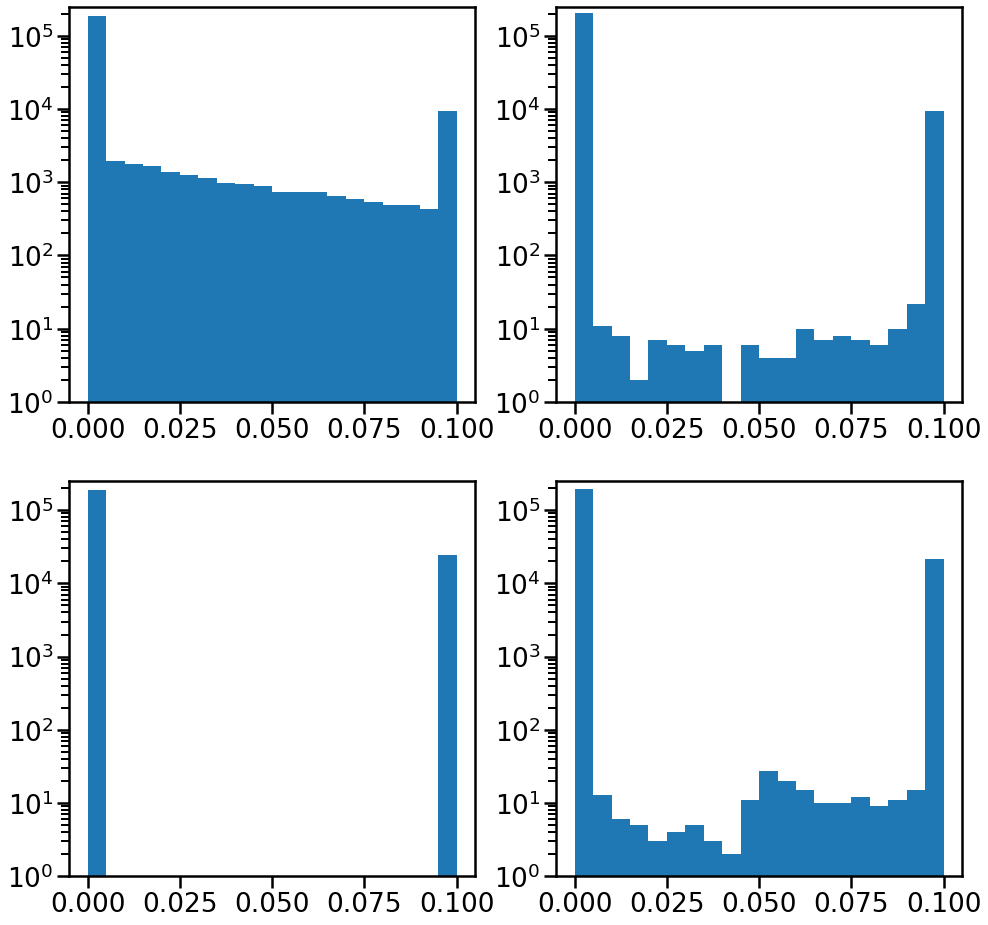

In [5]:
sns.set_context('poster', font_scale=1.2)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.hist(v, bins=[k*0.005 for k in range(0, 21)], log=True)
plt.ylim(1, 250000)
# plt.yscale('log')

plt.subplot(222)
plt.hist(target_highest_centrality_increase, bins=[k*0.005 for k in range(0, 21)], log=True)
plt.ylim(1, 250000)
# plt.yscale('log')

plt.subplot(223)
plt.hist(target_lowest_vaccination_increase, bins=[k*0.005 for k in range(0, 21)], log=True)
plt.ylim(1, 250000)
# plt.yscale('log')

plt.subplot(224)
plt.hist(target_random_increase, bins=[k*0.005 for k in range(0, 21)], log=True)
plt.ylim(1, 250000)
# plt.yscale('log')



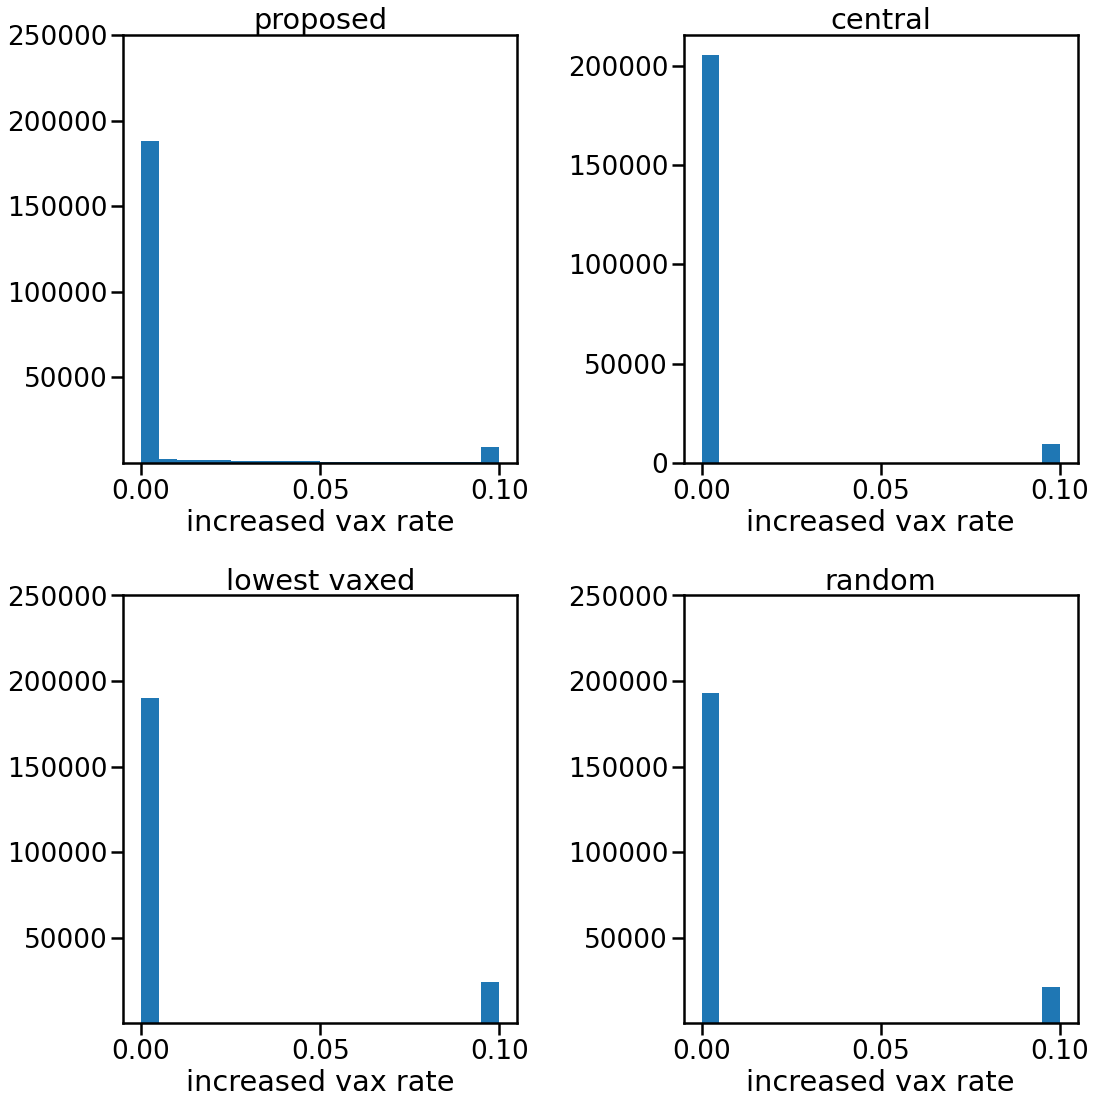

In [6]:
sns.set_context('poster', font_scale=1.2)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.hist(v, bins=[k*0.005 for k in range(0, 21)])#, log=True)
plt.ylim(1, 250000)
plt.title('proposed')
plt.xlabel('increased vax rate')


plt.subplot(222)
plt.hist(target_highest_centrality_increase, bins=[k*0.005 for k in range(0, 21)])#, log=True)
plt.title('central')
plt.xlabel('increased vax rate')


plt.subplot(223)
plt.hist(target_lowest_vaccination_increase, bins=[k*0.005 for k in range(0, 21)])#, log=True)
plt.ylim(1, 250000)
plt.title('lowest vaxed')
plt.xlabel('increased vax rate')

plt.subplot(224)
plt.hist(target_random_increase, bins=[k*0.005 for k in range(0, 21)])#, log=True)
plt.ylim(1, 250000)
plt.title('random')
plt.xlabel('increased vax rate')

plt.tight_layout()
plt.savefig('../results/campaign_dis_2022.pdf')